In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
import pickle
import re

In [22]:
# Download stopwords
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
# Load data
data = pd.read_csv(r"Data\amazon_alexa.tsv", delimiter='\t', quoting=3)
data.head()
data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [ ]:
#Getting and dropping the records where 'verified_reviews' is null 

data[data['verified_reviews'].isna() == True]
data.dropna(inplace=True)

In [4]:
# Data preprocessing
data['length'] = data['verified_reviews'].apply(len)

C:\Users\User\OneDrive\Documents\Python\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


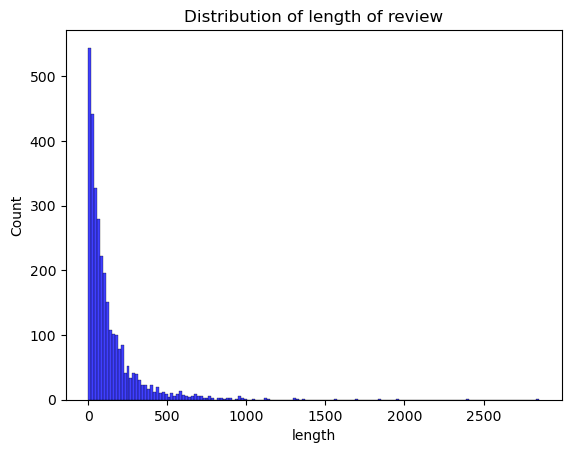

In [5]:
# Plotting the distributions
sns.histplot(data['length'], color='blue').set(title='Distribution of length of review')
plt.show()

In [6]:
# Preprocessing and stemming
corpus = []
stemmer = PorterStemmer()
for review in data['verified_reviews']:
    review = re.sub('[^a-zA-Z]', ' ', review)
    review = review.lower().split()
    review = [stemmer.stem(word) for word in review if word not in STOPWORDS]
    corpus.append(' '.join(review))

In [7]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=2500)
X = tfidf.fit_transform(corpus).toarray()
y = data['feedback'].values

In [8]:
# Save the TF-IDF vectorizer
pickle.dump(tfidf, open('Models/tfidfVectorizer.pkl', 'wb'))

In [9]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15, stratify=y)

In [10]:
# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=15)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Scale the data
scaler = MinMaxScaler()
X_train_scl = scaler.fit_transform(X_train_res)
X_test_scl = scaler.transform(X_test)

# Save the scaler
pickle.dump(scaler, open('Models/scaler.pkl', 'wb'))

In [11]:
# Model training and evaluation functions
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_preds = model.predict(X_test)
    cm = confusion_matrix(y_test, y_preds)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    cm_display.plot()
    plt.show()
    accuracy = accuracy_score(y_test, y_preds)
    return accuracy

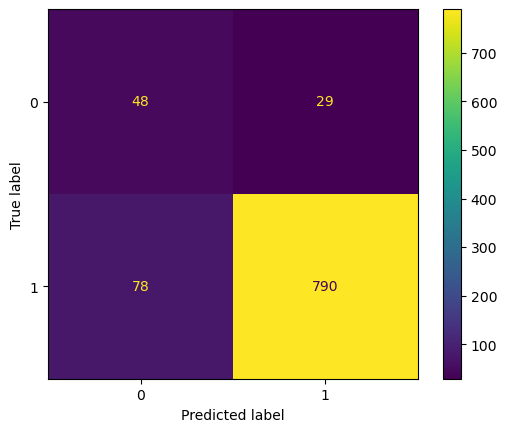

Ensemble Classifier Accuracy: 0.8867724867724868


In [12]:
# Ensemble of classifiers
model_rf = RandomForestClassifier(n_estimators=300)
model_xgb = XGBClassifier(n_estimators=300)
model_gb = GradientBoostingClassifier(n_estimators=300)
voting_clf = VotingClassifier(estimators=[
    ('rf', model_rf), ('xgb', model_xgb), ('gb', model_gb)], voting='hard')

ensemble_accuracy = evaluate_model(voting_clf, X_train_scl, y_train_res, X_test_scl, y_test)
print("Ensemble Classifier Accuracy:", ensemble_accuracy)


In [14]:
# Hyperparameter tuning for XGBoost
params = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 300, 500],
    'colsample_bytree': [0.3, 0.7]
}
grid_search = GridSearchCV(estimator=model_xgb, param_grid=params, cv=StratifiedKFold(n_splits=5), verbose=1, n_jobs=-1)
grid_search.fit(X_train_scl, y_train_res)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=300,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.3, 0.7],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 6, 9],
                         'n_estimators': [100, 300, 500]},
             verbose=1)

In [15]:
# Best parameters
print("Best Parameter Combination:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

Best Parameter Combination: {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 500}
Best CV Score: 0.9491358024691359


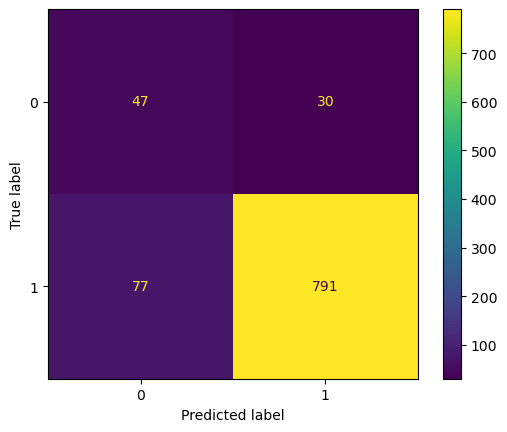

Final Model Accuracy: 0.8867724867724868


In [16]:
# Final evaluation on the test set with the best parameters
best_model = grid_search.best_estimator_
final_accuracy = evaluate_model(best_model, X_train_scl, y_train_res, X_test_scl, y_test)
print("Final Model Accuracy:", final_accuracy)

In [17]:
# Save the best model
pickle.dump(best_model, open('Models/best_model_xgb.pkl', 'wb'))